In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn import datasets
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [4]:
# Taken from Richard's "Reprod Figure 2"

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def generate_datasets(n_samples, datasets): 
    # Taken from : https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                          noise=.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    # Default parameters.
    default_base = {'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1}

    data = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                         'quantile': .2, 'n_clusters': 2,
                         'min_samples': 20, 'xi': 0.25}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2,
                  'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
        (aniso, {'eps': .15, 'n_neighbors': 2,
                 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
        (blobs, {}),
    ]
    
    return data

In [6]:
# def split_train_eval(X, y, frac_eval):
    
#     if frac_eval == 0:
#         return X, y, [], []
    
#     n = len(y)
#     n_eval = int(np.floor(frac_eval*n))
#     eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
#     X_eval = X[eval_indices, :]
#     y_eval = y[eval_indices]
#     X = np.delete(X, eval_indices, axis = 0)
#     y = np.delete(y, eval_indices, axis = 0)
    
#     return X, y, X_eval, y_eval

In [7]:
def plot_settings(axes, colors, names, data):
    for i_dataset, (dataset, algo_params) in enumerate(data):
        X, y = dataset
        
        # Assumes y is in {0, ..., K}
        axes[i_dataset].scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
        axes[i_dataset].set_xticks(())
        axes[i_dataset].set_yticks(())

        axes[i_dataset].set_ylabel(names[i_dataset])

In [8]:
# Data generating parameters.
# n_samples = 1000
# data = generate_datasets(n_samples, datasets)

# colors = ["#2166ac", "#c51b7d", "#d95f02"]
# names = ['Annulus', 'Cresent Moons', 'Class-Dependent Covariance', 'Ellyptical Gaussians', 'Scattered Means']

# sns.set(font_scale = 1.4)
# sns.set_style("ticks")
# plt.rcParams["font.family"] = "sans-serif"
# fig, axes = plt.subplots(len(data), 1, figsize = (5, 20))

# plot_settings(axes, colors, names, data)
# plt.tight_layout()
# plt.show()

In [9]:
# def estimate_mi(X, y, label, obj, frac_eval, base = 2):
#     if label == 'UF':
#         X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#         obj.fit(X, y)
#         return obj.estimate_mutual_info(X_eval)
#     elif label == 'KSG':
#         return ee.mi(X, np.array(y).reshape(-1, 1))
#     elif label == 'Mixed KSG':
#         return mixed.Mixed_KSG(X, y.reshape(-1, 1))
#     elif label == 'IRF':
#         X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#         obj.fit(X, y)
        
#         _, counts = np.unique(y, return_counts=True)
#         H_Y = entropy(counts, base=base)
        
#         p = obj.predict_proba(X_eval)
#         H_YX = np.mean(entropy(p.T, base=base))
#         return H_Y - H_YX
#     else:
#         raise ValueError("Uncrecognized label!")

In [10]:
# def mutual_info_dist(n, frac_eval, algos, num_trials, parallel):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         data = generate_datasets(n, datasets)
#         ret = np.zeros((len(algos), len(data)))
#         for i_dataset, (dataset, algo_params) in enumerate(data):
#             X, y = dataset
#             for j in range(len(algos)):
#                 ret[j, i_dataset] = estimate_mi(X, y, algos[j]['label'], algos[j]['instance'], frac_eval)
#         return ret
    
#     if parallel:
#         predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_mutual_info = np.zeros((num_trials, len(algos), 5))
#         for t in tqdm_notebook(range(num_trials)):
#             predicted_mutual_info[t, :, :] = worker(t)
            
#     return predicted_mutual_info

# def mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = False):
#     # Repeat for all 'n', and save output in the 'algos' array.
#     mutual_info_range = np.zeros((len(sample_sizes), num_trials, len(algos), 5))
#     for i in range(len(sample_sizes)):
#         mutual_info_range[i, :, :, :] = mutual_info_dist(sample_sizes[i],
#                                                          frac_eval, 
#                                                          algos, 
#                                                          num_trials,
#                                                          parallel = parallel)
        
#     for j in range(len(algos)):
#         algos[j]['mutual_info_by_n'] = mutual_info_range[:, :, j, :]
        
#     with open('algos_fig5.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('sample_sizes_fig5.pkl', 'wb') as f:
#         pickle.dump(sample_sizes, f)

In [11]:
def estimate_mi(X, y, label, base = np.exp(1)):
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
        
    if label == "UF":
        # UF
        return (est_H_Y - cef_estimate(np.array(X), y, 300, .32, depth = 30))
        
        # CART
        # cart_out = CART_estimate(X, y)
    elif label == "IRF":    
        # IRF
        frac_eval = 0.3
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
        irf_obj.fit(X_train, y_train)
        p = irf_obj.predict_proba(X_eval)
        return (est_H_Y - np.mean(entropy(p.T, base = base))) 
    elif label == "KSG": 
        # KSG
        return ee.mi(X, np.array(y).reshape(-1, 1))
    elif label == "Mixed KSG":     
        # MKSG
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Uncrecognized label!")

In [12]:
def get_mutual_info_vs_n(sample_sizes, num_trials):
    
    labels = ["UF", "IRF", "KSG", "Mixed KSG"]
    num_settings = 5
    num_n = len(sample_sizes)
    
    uf = np.zeros((num_n, num_trials, num_settings))
    irf = np.zeros((num_n, num_trials, num_settings))
    ksg = np.zeros((num_n, num_trials, num_settings))
    mksg = np.zeros((num_n, num_trials, num_settings))
    results = [uf, irf, ksg, mksg]
    
    # This worker is just for one algorithm.
    def worker(t):
        out = []
        data = generate_datasets(elem, datasets)
        for i_dataset, (dataset, algo_params) in enumerate(data):
            X, y = dataset
            out.append(estimate_mi(X, y, label, base = np.exp(1)))
        return tuple(out)

    settings = ['annulus', 'cresent', 'class_dep_cov', 'ellyptical', 'scattered']
    for i, elem in enumerate(sample_sizes):
        for j, label in enumerate(labels):
            # num_trials by num_settings
            output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
            for s in range(len(settings)):
                results[j][i, :, s] = output[:, s]
    
    algo_names = ['uf', 'irf', 'ksg', 'mksg'] # Same as results
    for s, setting in enumerate(settings):
        for j, algo_name in enumerate(algo_names):
            filename = '%s_by_n_%s.pkl' % (algo_name, setting)
            to_dump = results[j][:, :, s]
            pickle.dump(to_dump, open(filename, 'wb'))
    pickle.dump(sample_sizes, open('sample_sizes.pkl', 'wb'))
            
        
#     pickle.dump(mus, open('mus.pkl', 'wb'))
#     pickle.dump(uf, open('uf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     pickle.dump(cart, open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     pickle.dump(irf, open('irf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     pickle.dump(ksg, open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     pickle.dump(mksg, open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

    return uf, irf, ksg, mksg

In [13]:
# Data.
sample_sizes = range(100, 2501, 300)
num_trials = 15
# frac_eval = 0.3
# n_estimators = 5

# Algorithms.
algos = [
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
        'filename' : 'irf'
    },
    {
#         'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
        'filename' : 'ksg'
    },
    {
#         'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
        'filename' : 'mksg'
    },
    {
#         'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
        'filename' : 'uf'
    },
]

# Other.
num_plotted_trials = 5
parallel = True

In [ ]:
# mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = parallel)
get_mutual_info_vs_n(sample_sizes, num_trials)

In [14]:
def plot_mutual_info_by_n(setting, algos, ax):
    sample_sizes = pickle.load(open('sample_sizes.pkl', 'rb'))
    for algo in algos:
        filename = '%s_by_n_%s.pkl' % (algo['filename'], setting)
        algo_results = pickle.load(open(filename, 'rb'))
        ax.plot(sample_sizes, 
                np.mean(algo_results, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])
        
        # Plot other trials as light lines.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    algo_results[:, t].flatten(),  
                    linewidth = 4, 
                    color = algo['color'],
                    alpha = 0.15)
        ax.set_ylim(bottom = -0.05)
        ax.set_ylim(top = 1.65)
        ax.set_ylabel("Estimated Mutual Info")
        # ax.set_xlabel("Sample Size")

In [ ]:
# def plot_mutual_info_by_n(axes, sample_sizes, algos, num_plotted_trials, num_settings):
#     for algo in algos:
#         # Plot the mean over trials as a solid line.
#         for s in range(num_settings):
#             axes[s].plot(sample_sizes, 
#                          np.mean(algo['mutual_info_by_n'][:, :, s], axis = 1).flatten(), 
#                          label = algo['label'], 
#                          linewidth = 2, 
#                          color = algo['color'])
            
#             # Plot other trials as light lines.
#             for t in range(num_plotted_trials):
#                 axes[s].plot(sample_sizes, 
#                              algo['mutual_info_by_n'][:, t, s].flatten(),  
#                              linewidth = 4, 
#                              color = algo['color'],
#                              alpha = 0.15)
#             axes[s].set_ylim(bottom = -0.05)
#             axes[s].set_ylabel("Estimated Mutual Info")
#             axes[s].set_xlabel("Sample Size")

In [25]:
def plot_fig5():
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    # plt.figure()
    plt.rcParams["font.family"] = "sans-serif"
    num_settings = 5
    
    fig, axes = plt.subplots(num_settings, 2, figsize = (14,25))
    
    colors = ["#2166ac", "#c51b7d", "#d95f02"]
    names = ['Annulus', 'Cresent Moons', 'Class-Dependent Covariance', 'Ellyptical Gaussians', 'Scattered Means']
    settings = ['annulus', 'cresent', 'class_dep_cov', 'ellyptical', 'scattered']
    
    plot_settings(axes[:,0], colors, names, generate_datasets(1000, datasets))
    for s, setting in enumerate(settings):
        plot_mutual_info_by_n(setting, algos, axes[s,1])
    
    axes[num_settings-1, 1].legend(loc = "lower right")
    axes[0, 0].set_title("Setting")
    axes[0, 1].set_title("Mutual Information versus Sample Size")
    
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    # plt.tight_layout()
    plt.savefig("fig5.pdf")
    plt.show()

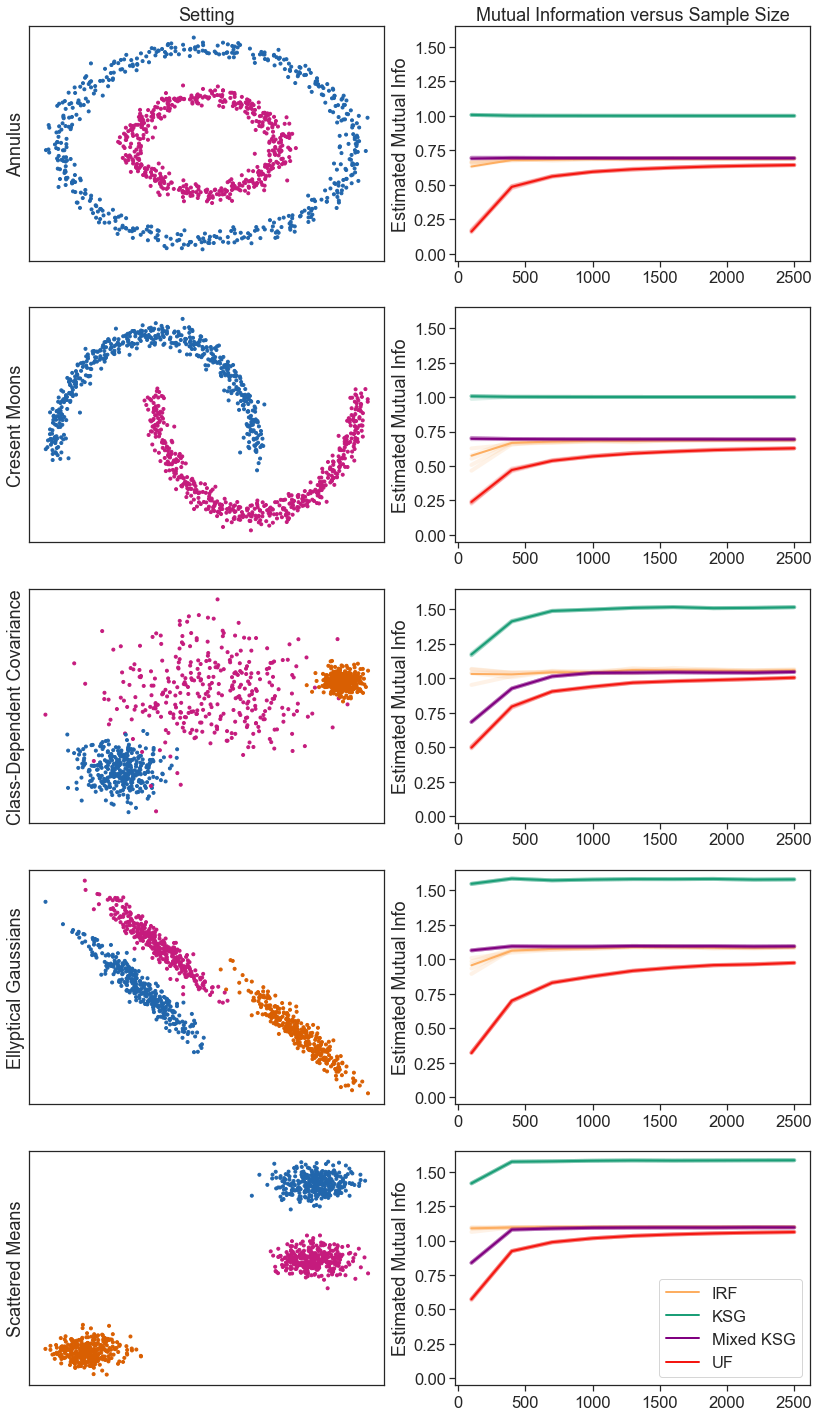

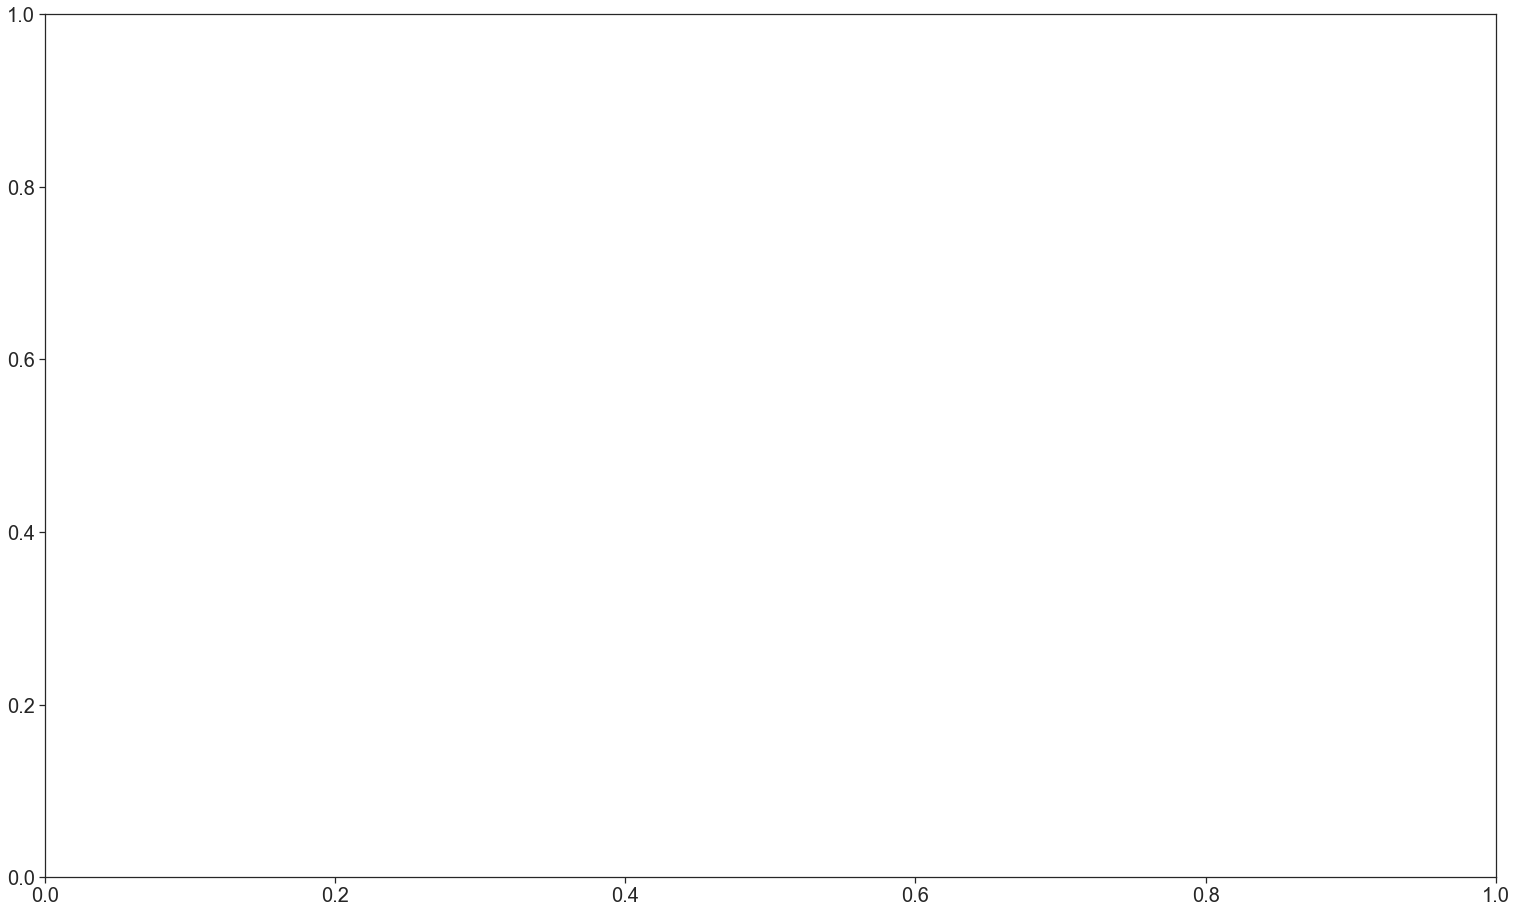

In [26]:
plot_fig5()

In [21]:
plt.clf()

<Figure size 432x288 with 0 Axes>